In [37]:
## Lotka-Volterra Example

In [38]:
import numpy as np

from numpy import linalg as LA

from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt

import time

import pymc3 as pm

import theano.tensor as tt

In [39]:

class LotkaVolterra:
    
    def __init__(self, tol, numDataPoints):
        
        self.tol = tol
        
        self.T = 15
              
        self.numDataPoints = numDataPoints
        
        self.numData = 50
        
        self.t_star = np.linspace(0.0, self.T, self.numData)
        
        self.t_eval = self.t_star[1:self.numDataPoints+1]
        
        self.sigf = 1
        
        self.true_theta = [10., 5., 1., 0.1, 1.5, 0.75]
        
    def setObservations(self, data_X):
        
        self.data_times = self.t_star[0:self.numDataPoints]
        
        self.data_Prey =  data_X[0, 0:self.numDataPoints]
        self.data_Pred = data_X[1, 0:self.numDataPoints]
              
    
    def dXdt(self,t, X, a, b, c, d):
        """ Return the growth rate of fox and rabbit populations. """
        
        return np.array([a*X[0] - b*X[0]*X[1], -c*X[1] + d*b*X[0]*X[1]])
    
    def simulate(self, theta):
        P0, Q0, a, b, c, d = theta
        sol = solve_ivp(self.dXdt, [0, self.t_eval[-1]], [P0, Q0], t_eval = self.data_times, rtol = self.tol, args=(a, b, c, d))
        return sol.y
        
        
    def simulateData(self, dataSeed = 2020, sig = 1.0, plotData = False):
        
        P0, Q0, a, b, c, d = self.true_theta
        
        sol = solve_ivp(self.dXdt, [0, self.T], [P0, Q0], t_eval = self.t_star, args=(a, b, c, d))
        
        np.random.seed(dataSeed) # Set seed for reproducability
        
        data = sol.y + np.random.normal(0.0, sig, size=(2,self.numData))
        
        if(plotData):        
            _, ax = plt.subplots(figsize=(12,4))
            ax.plot(data[0,:], 'x', label='prey')
            ax.plot(data[1,:], 'x', label='predator')
            ax.set_xlabel('Time')
            ax.set_ylabel('Population')
            ax.set_title('Observed data')
            ax.legend();
            
        return data
    
    def logDensity(self, theta):
        
        output = self.simulate(theta)    
        
        misfit_Prey = np.sum((output[0,:] - self.data_Prey)**2)
        
        misfit_Pred = np.sum((output[1,:] - self.data_Pred)**2)
        
        logDensity =  - (0.5 / self.sigf ** 2) * (misfit_Prey + misfit_Pred)
        
        return logDensity
        
        
        




In [40]:
numLevels = 3
factor = 5

# Number of draws from the distribution
ndraws = 1000

# Number of burn-in samples
nburn = 100

# MLDA and Metropolis tuning parameters
tune = True
tune_interval = 100
discard_tuning = True

# Number of independent chains
nchains = 2

# Subsampling rate for MLDA
nsub = 10

# Do blocked/compounds sampling in Metropolis and MLDA 
# Note: This choice applies only to the coarsest level in MLDA 
# (where a Metropolis sampler is used), all other levels use block sampling
blocked = False

# Data generation seed
data_seed = 2020

# Sampling seed
sampling_seed = 12345


-44.03813757190868


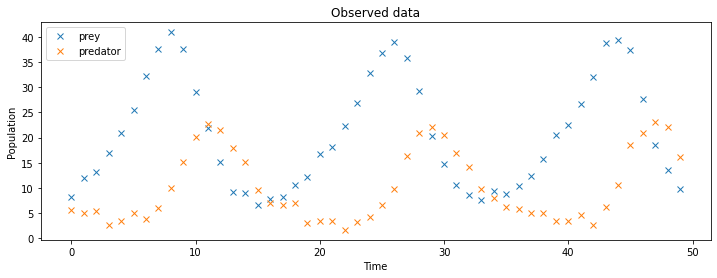

In [41]:
tol = [None] * numLevels
numData = [None] * numLevels
models = [None] * numLevels

param = ['P0', 'Q0', 'a', 'b', 'c', 'd']

nparam = len(param)

# Setup a Hierarchy of Model with descreasing time step size (dt) and increasing amount of data.
tol[0] = 1e-2
numData = [10,25,50]
for i in range(1,numLevels):
    tol[i] = tol[i-1] / factor
for i in range(numLevels):
    models[i] = LotkaVolterra(tol[i],numData[i])


# Generate True Data Using Finest Model

data = models[-1].simulateData(plotData = True) # Simulate Solution on finest level

for i in range(numLevels):
    models[i].setObservations(data)

    
print(models[-1].logDensity(models[-1].true_theta))

In [42]:
np.random.seed(sampling_seed)

In [43]:
class LogLike(tt.Op):
    # Function simply wraps Log-Likelihood calculation in Theano Op
    itypes = [tt.dvector]  # expects a vector of parameter values when called
    otypes = [tt.dscalar]  # outputs a single scalar value (the log likelihood)

    def __init__(self, my_model):
        # add inputs as class attributes
        self.my_model = my_model

    def perform(self, node, inputs, outputs):
        # the method that is used when calling the Op
        theta = inputs[0]  # this will contain my variables
        # call the log-likelihood function
        logl = self.my_model.logDensity(theta)
        outputs[0][0] = np.array(logl) # output the log-likelihood
        
# create Theano Ops to wrap likelihoods of all model levels and store them in list
logl = []
for m in models:
    logl.append(LogLike(m))

In [44]:
# Set up models in pymc3 for each level - excluding finest model level
coarse_models = []
for j in range(numLevels - 1):
    
    with pm.Model() as model:
        # uniform priors on parameters
        parameters = []
        
        # Need to write out the parameters with variables
        
        BoundedNormal = pm.Normal
        
        parameters.append(BoundedNormal('P0', mu=10.0, sd=0.1))
        parameters.append(BoundedNormal('Q0', mu=5.0, sd=1.))
        parameters.append(BoundedNormal('a', mu=1.0, sd=0.1))
        parameters.append(BoundedNormal('b', mu=0.1, sd=0.1))
        parameters.append(BoundedNormal('c', mu=1.5, sd=0.1))
        parameters.append(BoundedNormal('d', mu=1.0, sd=0.2))
        
        # convert m and c to a tensor vector
        theta = tt.as_tensor_variable(parameters)

        # use a DensityDist (use a lamdba function to "call" the Op)
        ll = logl[j]
        pm.DensityDist('likelihood', lambda v: ll(v), observed={'v': theta})

    coarse_models.append(model)

In [45]:
# Set up finest model and perform inference with PyMC3, using the MLDA algorithm
# and passing the coarse_models list created above.
method_names = []
traces = []
runtimes = []
acc = []
ess = []
ess_n = []
performances = []

with pm.Model():
    
    # Uniform priors on parameters
    parameters = []
    BoundedNormal = pm.Normal
        
    parameters.append(BoundedNormal('P0', mu=10.0, sd=0.1))
    parameters.append(BoundedNormal('Q0', mu=5.0, sd=1.))
    parameters.append(BoundedNormal('a', mu=1.0, sd=0.1))
    parameters.append(BoundedNormal('b', mu=0.1, sd=0.1))
    parameters.append(BoundedNormal('c', mu=1.5, sd=0.1))
    parameters.append(BoundedNormal('d', mu=1.0, sd=0.2))

    # Convert m and c to a tensor vector
    theta = tt.as_tensor_variable(parameters)

    # use a DensityDist (use a lamdba function to "call" the Op)
    pm.DensityDist('likelihood', lambda v: logl[-1](v), observed={'v': theta})
    
    # Find Map
    
    approxMap = None #pm.find_MAP()

    # Initialise an MLDA step method object, passing the subsampling rate and
    # coarse models list
    # Also initialise a Metropolis step method object
    #step_metropolis = pm.Metropolis(tune=tune, tune_interval=tune_interval, blocked=blocked, start = approxMap)
    
    step_mlda = pm.MLDA(subsampling_rates=nsub, coarse_models=coarse_models,
                        tune=tune, tune_interval=tune_interval, base_blocked=blocked, start = approxMap)
    

    # Inference!
    # Metropolis
    '''
    t_start = time.time()
    method_names.append("Metropolis")
    traces.append(pm.sample(draws=ndraws, step=step_metropolis,
                            chains=nchains, tune=nburn,
                            discard_tuned_samples=discard_tuning,
                            random_seed=sampling_seed))
    runtimes.append(time.time() - t_start)
    '''
    # MLDA
    t_start = time.time()
    method_names.append("MLDA")
    traces.append(pm.sample(draws=ndraws, step=step_mlda,
                            chains=nchains, tune=nburn,
                            discard_tuned_samples=discard_tuning,
                            random_seed=sampling_seed))
    runtimes.append(time.time() - t_start)
    

/Users/gmingas/projects/pymc3/pymc3/step_methods/metropolis.py:1053: UserWarning: The MLDA implementation in PyMC3 is very young. You should be extra critical about its results.
  'The MLDA implementation in PyMC3 is very young. '
Multiprocess sampling (2 chains in 4 jobs)
MLDA: [d, c, b, a, Q0, P0]


RuntimeError: Chain 1 failed.

In [ ]:
for i, trace in enumerate(traces):
    acc.append(trace.get_sampler_stats('accepted').mean())
    ess.append(np.array(pm.ess(trace).to_array()))
    ess_n.append(ess[i] / len(trace) / trace.nchains)
    performances.append(ess[i] / runtimes[i])
    print(f'\nSampler {method_names[i]}: {len(trace)} drawn samples in each of '
          f'{trace.nchains} chains.'
          f'\nRuntime: {runtimes[i]} seconds'
          f'\nAcceptance rate: {acc[i]}'
          f'\nESS list: {ess[i]}'
          f'\nNormalised ESS list: {ess_n[i]}'
          f'\nESS/sec: {performances[i]}')

In [ ]:
# Print true theta values and pymc3 sampling summary
for i, trace in enumerate(traces):
    pm.plots.traceplot(trace)

In [ ]:


print(approxMap)